# Prosocial Chimps

##### Data: data/chimpanzees2.csv

![](images/pchimps.png)

>Chimpanzee prosociality experiment, as seen from the perspective of the focal animal. The left and right levers are indicated in the foreground. Pulling either expands an accordion device in the center, pushing the food trays towards both ends of the table. Both food trays close to the focal animal have food in them. Only one of the food trays on the other side contains food. The partner condition means another animal, as pictured, sits on the other end of the table. Otherwise, the other end was empty. (McElreath 293)



## Seeing the Data

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
df=pd.read_csv("data/chimpanzees2.csv", sep=";")
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,0,0,1,2,0,1,0
1,1,0,0,1,4,0,0,1
2,1,0,0,1,6,1,0,0
3,1,0,0,1,8,0,1,0
4,1,0,0,1,10,1,1,1


In [63]:
df.head(100)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,0,0,1,2,0,1,0
1,1,0,0,1,4,0,0,1
2,1,0,0,1,6,1,0,0
3,1,0,0,1,8,0,1,0
4,1,0,0,1,10,1,1,1
5,1,0,0,1,12,1,1,1
6,1,0,0,2,14,1,0,0
7,1,0,0,2,16,1,0,0
8,1,0,0,2,18,0,1,0
9,1,0,0,2,20,0,1,0


>We're going to focus on `pulled_left` as the outcome to predict, with `prosoc_left` and `condition` as predictor variables. The outcome `pulled_left` is a 0 or 1 indicator that the focal animal pulled the left-hand lever. The predictor `prosoc_left` is a 0/1 indicator that the left-hand lever was (1) or was not (0) attached to the prosocial option, the side with two pieces of food. The `condition` predictor is another 0/1 indicator, with value 1 for the partner condition and value 0 for the control condition. (McElreath 293)

In [3]:
df.shape

(504, 8)

In [4]:
gd={}
for k, v in df.groupby('actor'):
    temp = v.groupby(['condition', 'prosoc_left'])['pulled_left'].mean()
    gd[k] = temp.values
    #print(k, ldf.values)

In [5]:
gd

{1: array([ 0.33333333,  0.5       ,  0.27777778,  0.55555556]),
 2: array([1, 1, 1, 1]),
 3: array([ 0.27777778,  0.61111111,  0.16666667,  0.33333333]),
 4: array([ 0.33333333,  0.5       ,  0.11111111,  0.44444444]),
 5: array([ 0.33333333,  0.55555556,  0.27777778,  0.5       ]),
 6: array([ 0.77777778,  0.61111111,  0.55555556,  0.61111111]),
 7: array([ 0.77777778,  0.83333333,  0.94444444,  1.        ])}

## 3 different models

![](images/modelfull.png)

In [6]:
def full_model():
    with pm.Model() as ps1:
        betapc = pm.Normal("betapc", 0, 10)
        betap = pm.Normal("betap", 0, 10)
        alpha = pm.Normal('alpha', 0, 10)
        logitpi = alpha + (betap + betapc*df.condition)*df.prosoc_left
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
        
    return ps1

![](images/modelicept.png)

In [7]:
def ionly_model():
    with pm.Model() as ps0:
        alpha = pm.Normal('alpha', 0, 10)
        logitpi = alpha 
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
    return ps0

![](images/modelnocong.png)

In [8]:
def plonly_model():
    with pm.Model() as plonly:
        betap = pm.Normal("betap", 0, 10)
        alpha = pm.Normal('alpha', 0, 10)
        logitpi = alpha + betap*df.prosoc_left
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
    return plonly

In [9]:
ionly = ionly_model()
with ionly:
    trace_ionly=pm.sample(2000)

100%|██████████| 2000/2000 [00:01<00:00, 1294.47it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d99d0b8>]], dtype=object)

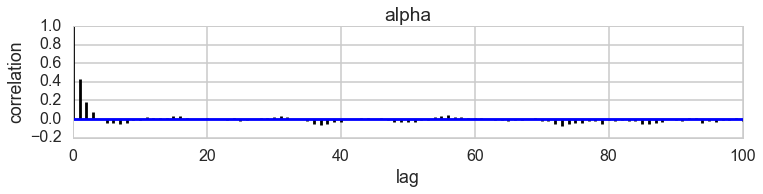

In [10]:
pm.autocorrplot(trace_ionly)

In [11]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

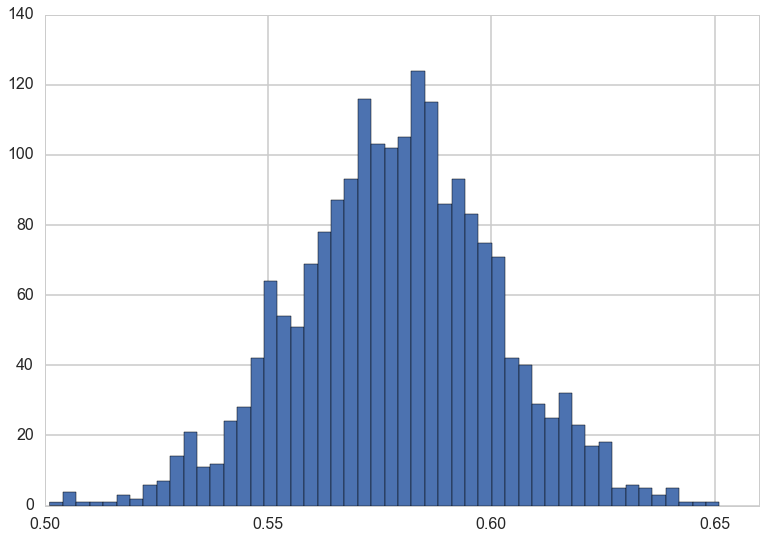

In [12]:
plt.hist(invlogit(trace_ionly['alpha']), bins=50);

In [13]:
pm.quantiles(invlogit(trace_ionly['alpha'])), np.mean(invlogit(trace_ionly['alpha']))

({2.5: 0.53243255337858819,
  25: 0.5644365978988698,
  50: 0.57934469075699768,
  75: 0.59336332316257956,
  97.5: 0.6230968437257266},
 0.5787415405818559)

In [14]:
full = full_model()
with full:
    trace_full=pm.sample(2000)

100%|██████████| 2000/2000 [00:04<00:00, 436.93it/s]


In [15]:
plonly = plonly_model()
with plonly:
    trace_plonly=pm.sample(2000)

100%|██████████| 2000/2000 [00:02<00:00, 704.87it/s]


## Model Comparison

In [16]:
def make_compare(names, traces, models, ic='WAIC'):
    comparedf=pm.compare(traces,models)
    temp=comparedf.sort_index()
    temp['Model']=names
    comparedf = temp.sort(ic).set_index('Model')
    return comparedf

In [17]:
names=['intercept only', 'full', 'prosocial left only']
dfc=make_compare(names, [trace_ionly, trace_full, trace_plonly],[ionly, full, plonly])
dfc

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
prosocial left only,680.791,2.14711,0,0.684034,9.35413,0,0
full,682.456,3.05751,1.66475,0.297566,9.41019,0.0250039,0
intercept only,688.022,1.04066,7.23134,0.0183998,7.06937,1.72363,0


In [18]:
def compare_plot(comp_df, ax=None):
    """
    Model comparison summary plot in the style of the one used in the book
    Statistical Rethinking by Richard McElreath.
    Parameters
    ----------
    comp_df: DataFrame
        The result of the pm.compare() function
    ax : axes
        Matplotlib axes. Defaults to None.
    Returns
    -------
    ax : matplotlib axes
    """
    if ax is None:
        _, ax = plt.subplots()

    yticks_pos, step = np.linspace(0, -1, (comp_df.shape[0] * 2) - 1, retstep=True)
    yticks_pos[1::2] = yticks_pos[1::2] + step / 2

    yticks_labels = [''] * len(yticks_pos)
    yticks_labels[0] = comp_df.index[0]
    yticks_labels[1::2] = comp_df.index[1:]

    data = comp_df.values
    min_ic = data[0, 0]

    ax.errorbar(x=data[:, 0], y=yticks_pos[::2], xerr=data[:, 4],
                fmt='ko', mfc='None', mew=1)
    ax.errorbar(x=data[1:, 0], y=yticks_pos[1::2],
                xerr=data[1:, 5], fmt='^', color='grey')

    ax.plot(data[:, 0] - (2 * data[:, 1]), yticks_pos[::2], 'ko')
    ax.axvline(min_ic, ls='--', color='grey')

    ax.set_yticks(yticks_pos)
    ax.set_yticklabels(yticks_labels)
    ax.set_xlabel('Deviance')
    lims=ax.get_ylim()
    ax.set_ylim(lims[0] + step/2., lims[1] - step/2.)
    return ax

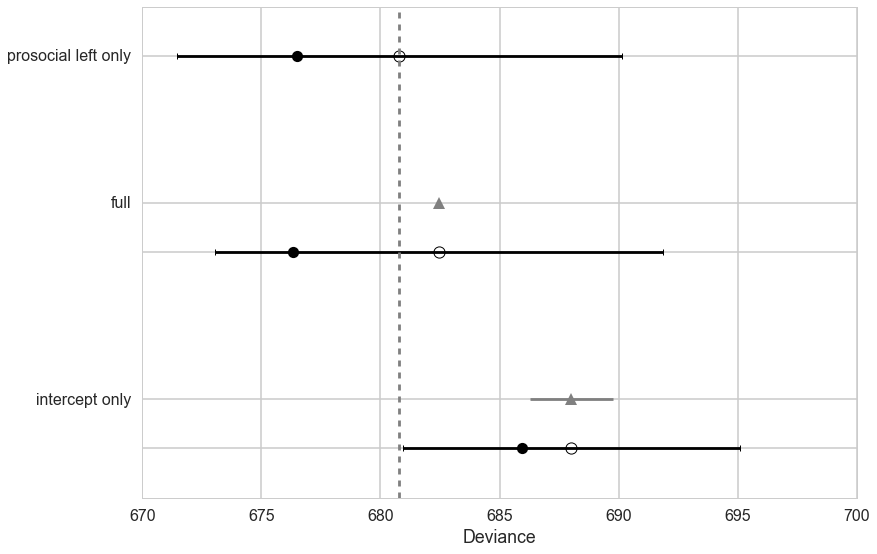

In [19]:
compare_plot(dfc)

In [20]:
pm.summary(trace_full)


betapc:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.097           0.266            0.008            [-0.598, 0.427]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.608         -0.275         -0.098         0.079          0.420


betap:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.610            0.232            0.007            [0.151, 1.067]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.151          0.449          0.608          0.767          1.067


alpha:

  Mean             SD               MC Error         95% HPD interval
  -----------------------

## Posteriors and Posterior predictives

In [21]:
def trace_or_zero(trace, name):
    if name in trace.varnames:
        return trace[name]
    else:
        return np.zeros(len(trace))

In [22]:
def model_pp(gridx, tracedict):
    temp = tracedict['alpha'] + gridx['P']*(tracedict['betap'] + tracedict['betapc']*gridx['C'])
    return temp

In [47]:
def compute_pp(lpgrid, trace, paramnames, sampdistrib, invlink, inner_pp):
    tdict={}
    for pn in paramnames:
        tdict[pn] = trace_or_zero(trace, pn)
    print(tdict.keys())
    tl=len(trace)
    gl=len(lpgrid)
    pp = np.empty((gl, tl))
    for i, v in enumerate(lpgrid):
        temp = inner_pp(lpgrid[i], tdict)
        pp[i,:] = sampdistrib(invlink(temp))
        #pp[i,:] = invlink(temp)
    return pp

In [48]:
import itertools
psleft = [0,1]
condition = [0,1]
xgrid = [{'C':v[0], 'P':v[1]} for v in itertools.product(condition, psleft)]

In [49]:
xgrid

[{'C': 0, 'P': 0}, {'C': 0, 'P': 1}, {'C': 1, 'P': 0}, {'C': 1, 'P': 1}]

In [50]:
from scipy.stats import bernoulli, binom

In [51]:
ppdivisor=7
def like_sample(p_array):
    ppdivisor=7
    return binom.rvs(ppdivisor, p=p_array)

In [52]:
ppfull = compute_pp(xgrid, trace_full, trace_full.varnames, like_sample, invlogit, model_pp)

dict_keys(['betapc', 'betap', 'alpha'])


In [53]:
ppfull

array([[ 4.,  2.,  3., ...,  3.,  6.,  5.],
       [ 5.,  4.,  5., ...,  4.,  6.,  5.],
       [ 5.,  3.,  4., ...,  4.,  1.,  2.],
       [ 3.,  4.,  3., ...,  5.,  4.,  5.]])

In [54]:
meanpp, stdpp = ppfull.mean(axis=1), ppfull.std(axis=1)

In [55]:
meanpp, stdpp

(array([ 3.574 ,  4.6335,  3.6285,  4.4335]),
 array([ 1.33023457,  1.28614842,  1.31433928,  1.28785781]))

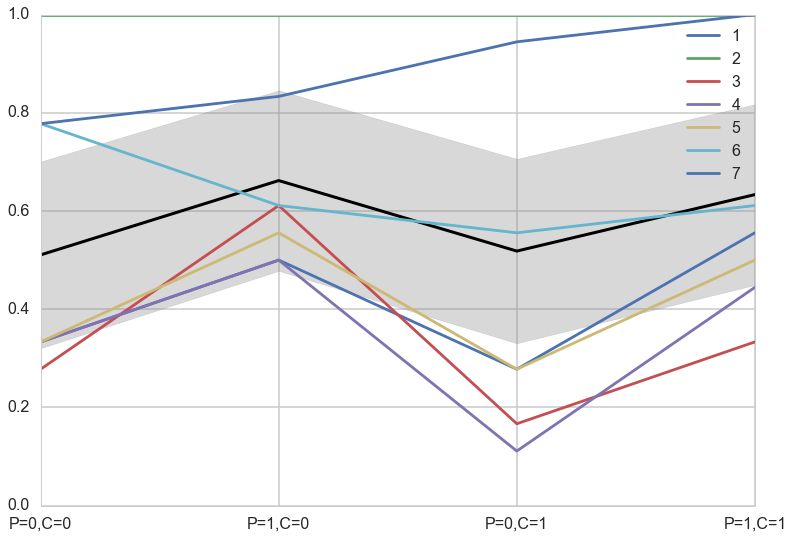

In [56]:
fmt = lambda d: ",".join([e+"="+str(d[e]) for e in d])
plt.plot(range(4),meanpp/ppdivisor, lw=3, color="black")
for i, chimp in enumerate(gd):
    plt.plot(range(4), gd[chimp], label=str(chimp))
plt.fill_between(range(4), (meanpp-stdpp)/ppdivisor, (meanpp+stdpp)/ppdivisor, alpha=0.3, color="gray")
plt.ylim([0,1])
plt.xticks(range(4),[fmt(e) for e in xgrid])
plt.legend();

## Ensemble the model

In [57]:
for m in dfc.index:
    print(m)

prosocial left only
full
intercept only


In [58]:
modeldict={
    "prosocial left only": trace_plonly,
    "full": trace_full,
    "intercept only": trace_ionly
}

In [59]:
def ensemble(grid, modeldict, paramnames, comparedf):
    accum_pp=0
    accum_weight=0
    for m in comparedf.index:
        weight = comparedf.ix[m]['weight']
        pp=compute_pp(grid, modeldict[m], paramnames, like_sample, invlogit, model_pp)
        print(m, weight, np.median(pp))
        accum_pp += pp*weight
        accum_weight +=weight
    return accum_pp/accum_weight

In [60]:
ppens = ensemble(xgrid, modeldict, ['alpha', 'betap', 'betapc'], dfc)

dict_keys(['betapc', 'betap', 'alpha'])
prosocial left only 0.684034358902 4.0
dict_keys(['betapc', 'betap', 'alpha'])
full 0.297565832533 4.0
dict_keys(['betapc', 'betap', 'alpha'])
intercept only 0.0183998085648 4.0


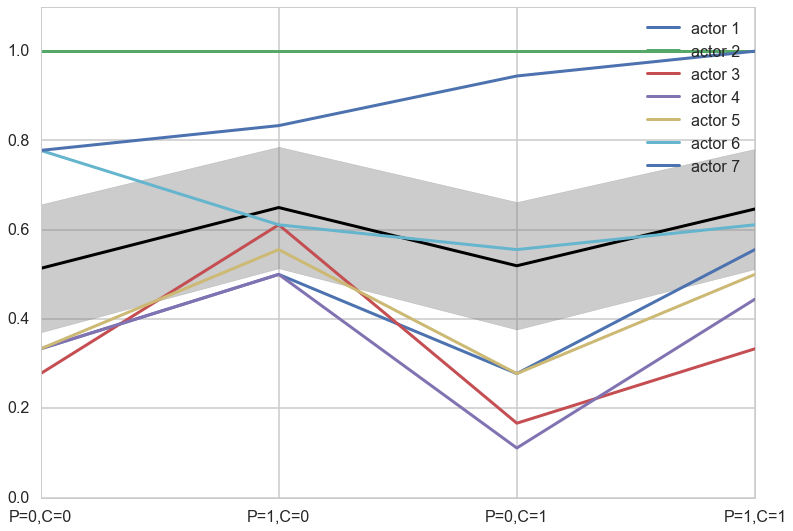

In [62]:
meanpp, stdpp = ppens.mean(axis=1), ppens.std(axis=1)
fmt = lambda d: ",".join([e+"="+str(d[e]) for e in d])
plt.plot(range(4),meanpp/ppdivisor, lw=3, color="black")
for i, chimp in enumerate(gd):
    plt.plot(range(4), gd[chimp], label="actor {}".format(chimp), lw=3)
plt.fill_between(range(4), (meanpp-stdpp)/ppdivisor, (meanpp+stdpp)/ppdivisor, alpha=0.4, color="gray")
plt.ylim([0,1.1])
plt.xticks(range(4),[fmt(e) for e in xgrid])
plt.legend();

## A heirarchical model

Here we have a varying intercepts model

![](images/multichimp.png)

In [64]:
def vi_model():
    with pm.Model() as vi:
        betapc = pm.Normal("betapc", 0, 10)
        betap = pm.Normal("betap", 0, 10)
        alpha = pm.Normal('alpha', 0, 10)
        sigma_actor = pm.HalfCauchy("sigma_actor", 1)
        alpha_actor = pm.Normal('alpha_actor', 0, sigma_actor, shape=7)
        logitpi = alpha + alpha_actor[df.index//72] + (betap + betapc*df.condition)*df.prosoc_left
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
        
    return vi

In [65]:
vi = vi_model()
with vi:
    vi_trace=pm.sample(10000)

100%|██████████| 10000/10000 [01:07<00:00, 147.13it/s]


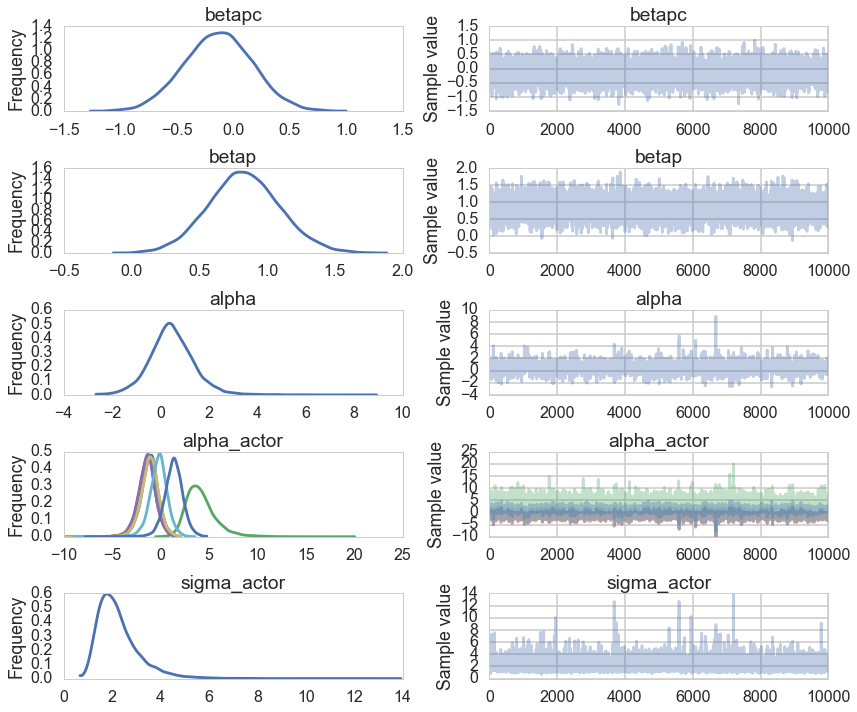

In [66]:
pm.traceplot(vi_trace);

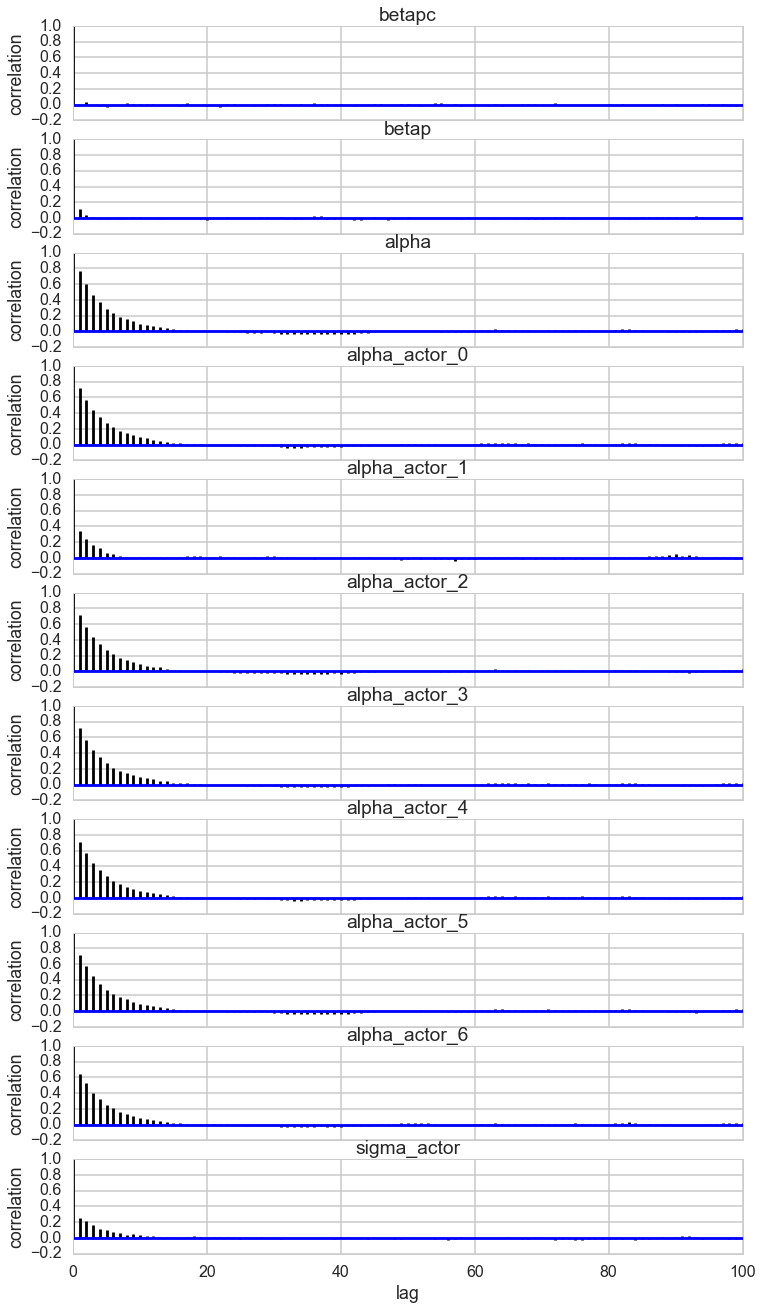

In [67]:
pm.autocorrplot(vi_trace);

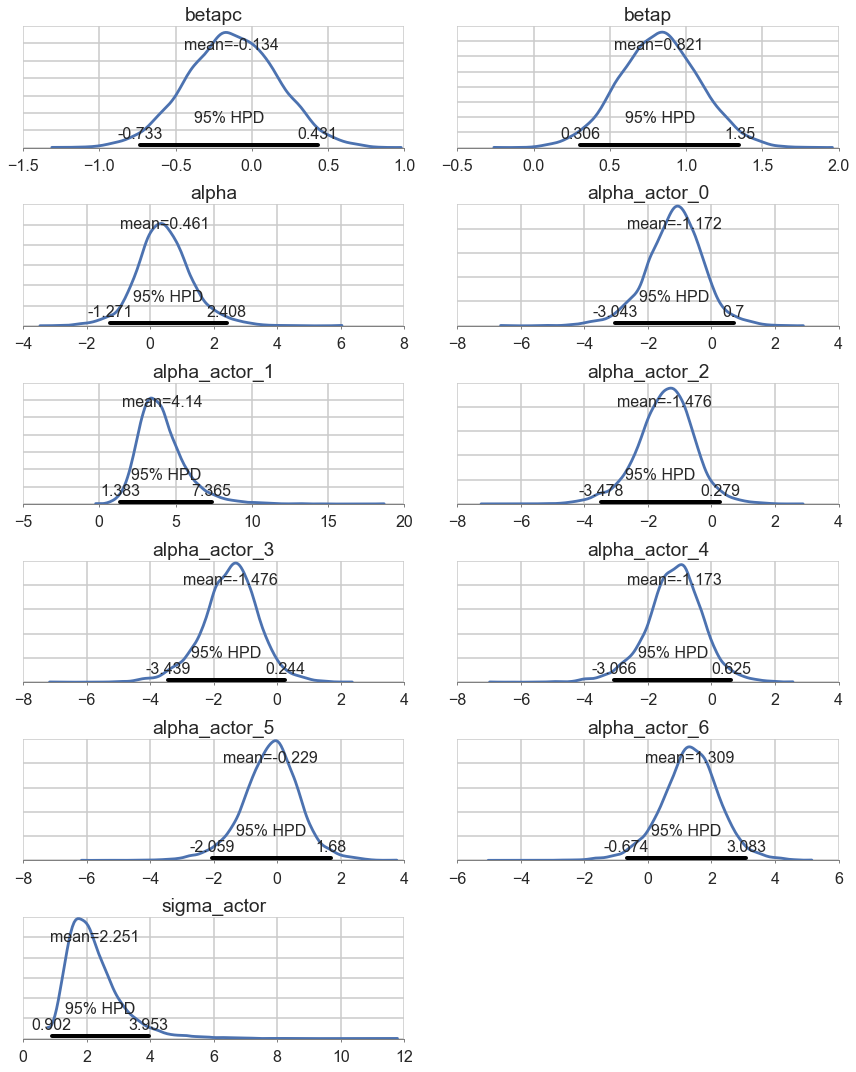

In [298]:
pm.plot_posterior(vi_trace, kde_plot=True);

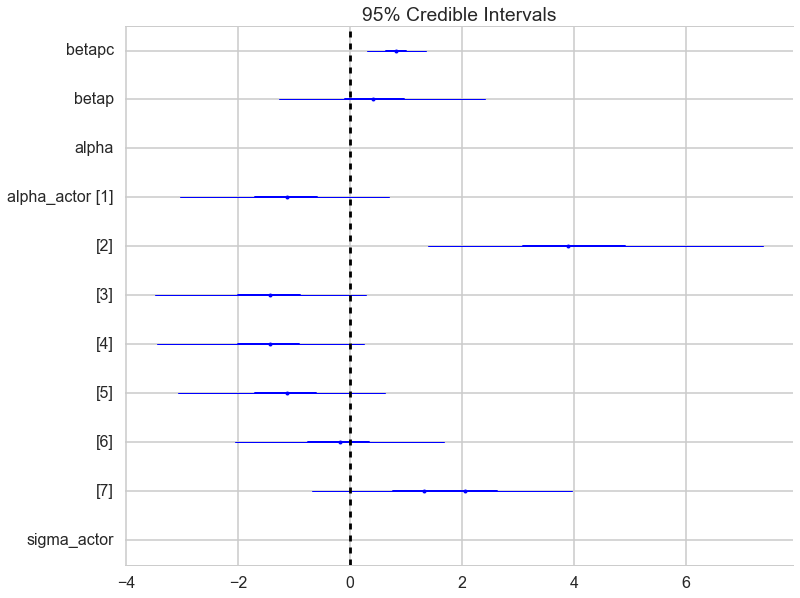

In [330]:
pm.forestplot(vi_trace);

In [299]:
trace.varnames

['betapc', 'betap', 'alpha', 'sigma_actor_log_', 'alpha_actor', 'sigma_actor']

In [69]:
np.exp(0.2)

1.2214027581601699

### Predictives are on individuals now

In [70]:
def like_sample_hier(p_array):
    return bernoulli.rvs(p=p_array)

In [71]:
def model_pp_hier(gridx, tracedict, ix):
    temp = tracedict['alpha'] + tracedict['alpha_actor'][:,ix]+gridx['P']*(tracedict['betap'] + tracedict['betapc']*gridx['C'])
    return temp

In [72]:
def compute_pp2(lpgrid, trace, paramnames, sampdistrib, invlink, inner_pp, ix):
    tdict=trace
    tl=len(trace)
    gl=len(lpgrid)
    pp = np.empty((gl, tl))
    for i, v in enumerate(lpgrid):
        temp = inner_pp(lpgrid[i], tdict, ix)
        pp[i,:] = invlink(temp)
    return pp

In [73]:
vi_trace.varnames

['betapc', 'betap', 'alpha', 'sigma_actor_log_', 'alpha_actor', 'sigma_actor']

In [74]:
vnames=['betapc', 'betap', 'alpha', 'alpha_actor']
pphier0=compute_pp2(xgrid, vi_trace, vnames, like_sample_hier, invlogit, model_pp_hier, 0)

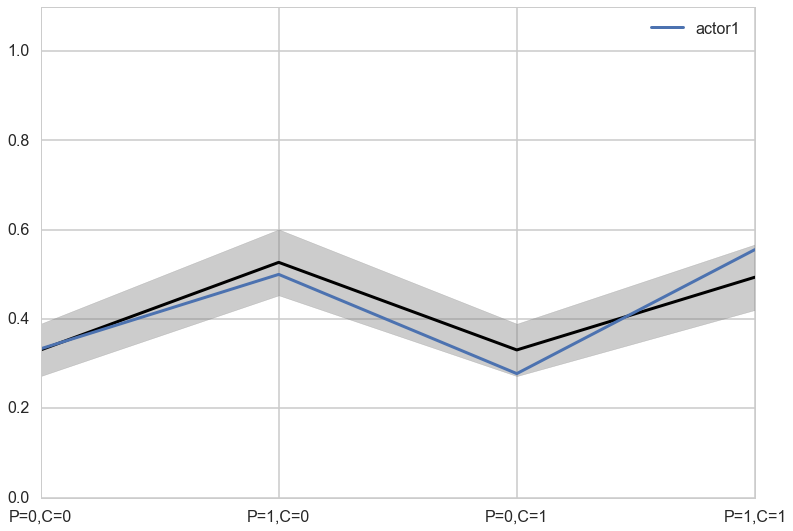

In [76]:
ppdivisor=1
meanpp, stdpp = pphier0.mean(axis=1), pphier0.std(axis=1)
fmt = lambda d: ",".join([e+"="+str(d[e]) for e in d])
plt.plot(range(4),meanpp/ppdivisor, lw=3, color="black")
plt.plot(range(4), gd[1], label="actor{}".format(1), lw=3)
plt.fill_between(range(4), (meanpp-stdpp)/ppdivisor, (meanpp+stdpp)/ppdivisor, alpha=0.4, color="gray")
plt.ylim([0,1.1])
plt.xticks(range(4),[fmt(e) for e in xgrid])
plt.legend();

In [78]:
pphier6=compute_pp2(xgrid, vi_trace, vnames, like_sample_hier, invlogit, model_pp_hier, 6)

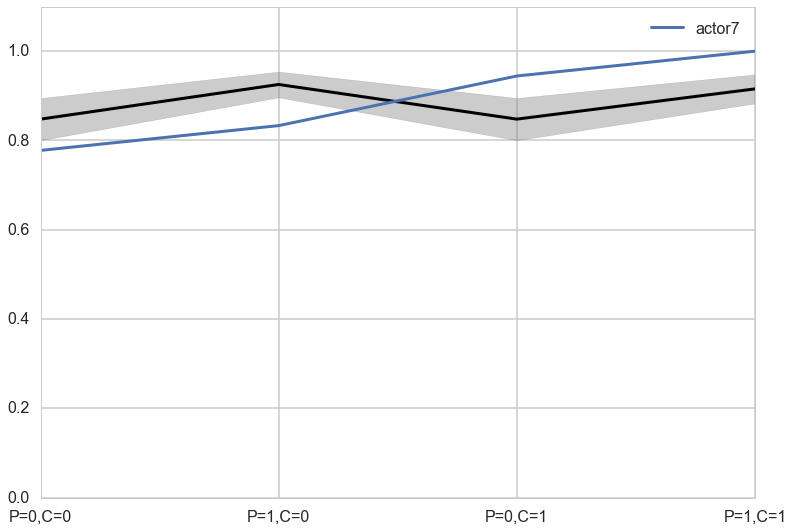

In [79]:
ppdivisor=1
meanpp, stdpp = pphier6.mean(axis=1), pphier6.std(axis=1)
fmt = lambda d: ",".join([e+"="+str(d[e]) for e in d])
plt.plot(range(4),meanpp/ppdivisor, lw=3, color="black")
plt.plot(range(4), gd[7], label="actor{}".format(7), lw=3)
plt.fill_between(range(4), (meanpp-stdpp)/ppdivisor, (meanpp+stdpp)/ppdivisor, alpha=0.4, color="gray")
plt.ylim([0,1.1])
plt.xticks(range(4),[fmt(e) for e in xgrid])
plt.legend();

## Varying experimental blocks as well

>The kind of data structure here is usually called a CROSS-CLASSIFIED multilevel model. It is cross-classified, because actors are not nested within unique blocks. If each chimpanzee had instead done all of his or her pulls on a single day, within a single block, then the data structure would instead be hierarchical. However, the model specification would typically be the same. So the model structure and code you'll see below will apply both to cross-classified designs and hierarchical designs. Other software sometimes forces you to treat these differently, on account of using a conditioning engine substantially less capable than MCMC. There are other types of “hierarchical” multilevel models, types that make adaptive priors for adaptive priors. It's turtles all the way down, recall (page 13). You'll see an example in the next chapter. But for the most part, people (or their software) nearly always use the same kind of model in both cases. (McElreath 371)

>Each pull is within a cluster of pulls belonging to an individual chimpanzee. But each pull is also within an experimental block, which represents a collection of observations that happened on the same day. So each observed pull belongs to both an actor (1 to 7) and a block (1 to 6). There may be unique intercepts for each actor as well as for each block. (McElreath 370-371)

![](images/multichimpcluster.png)

In [331]:
df.head(50)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,0,0,1,2,0,1,0
1,1,0,0,1,4,0,0,1
2,1,0,0,1,6,1,0,0
3,1,0,0,1,8,0,1,0
4,1,0,0,1,10,1,1,1
5,1,0,0,1,12,1,1,1
6,1,0,0,2,14,1,0,0
7,1,0,0,2,16,1,0,0
8,1,0,0,2,18,0,1,0
9,1,0,0,2,20,0,1,0


In [80]:
def viplusblock_model():
    with pm.Model() as vipb:
        betapc = pm.Normal("betapc", 0, 10)
        betap = pm.Normal("betap", 0, 10)
        alpha = pm.Normal('alpha', 0, 10)
        sigma_actor = pm.HalfCauchy("sigma_actor", 1)
        sigma_block = pm.HalfCauchy("sigma_block", 1)
        alpha_actor = pm.Normal('alpha_actor', 0, sigma_actor, shape=7)
        alpha_block = pm.Normal('alpha_block', 0, sigma_block, shape=6)
        logitpi = alpha + alpha_actor[df.index//72] + alpha_block[df.block.values -1]+ (betap + betapc*df.condition)*df.prosoc_left
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
        
    return vipb

In [82]:
vipb=viplusblock_model()
with vipb:
    trace_vipb = pm.sample(5000)

100%|██████████| 5000/5000 [00:48<00:00, 104.05it/s]


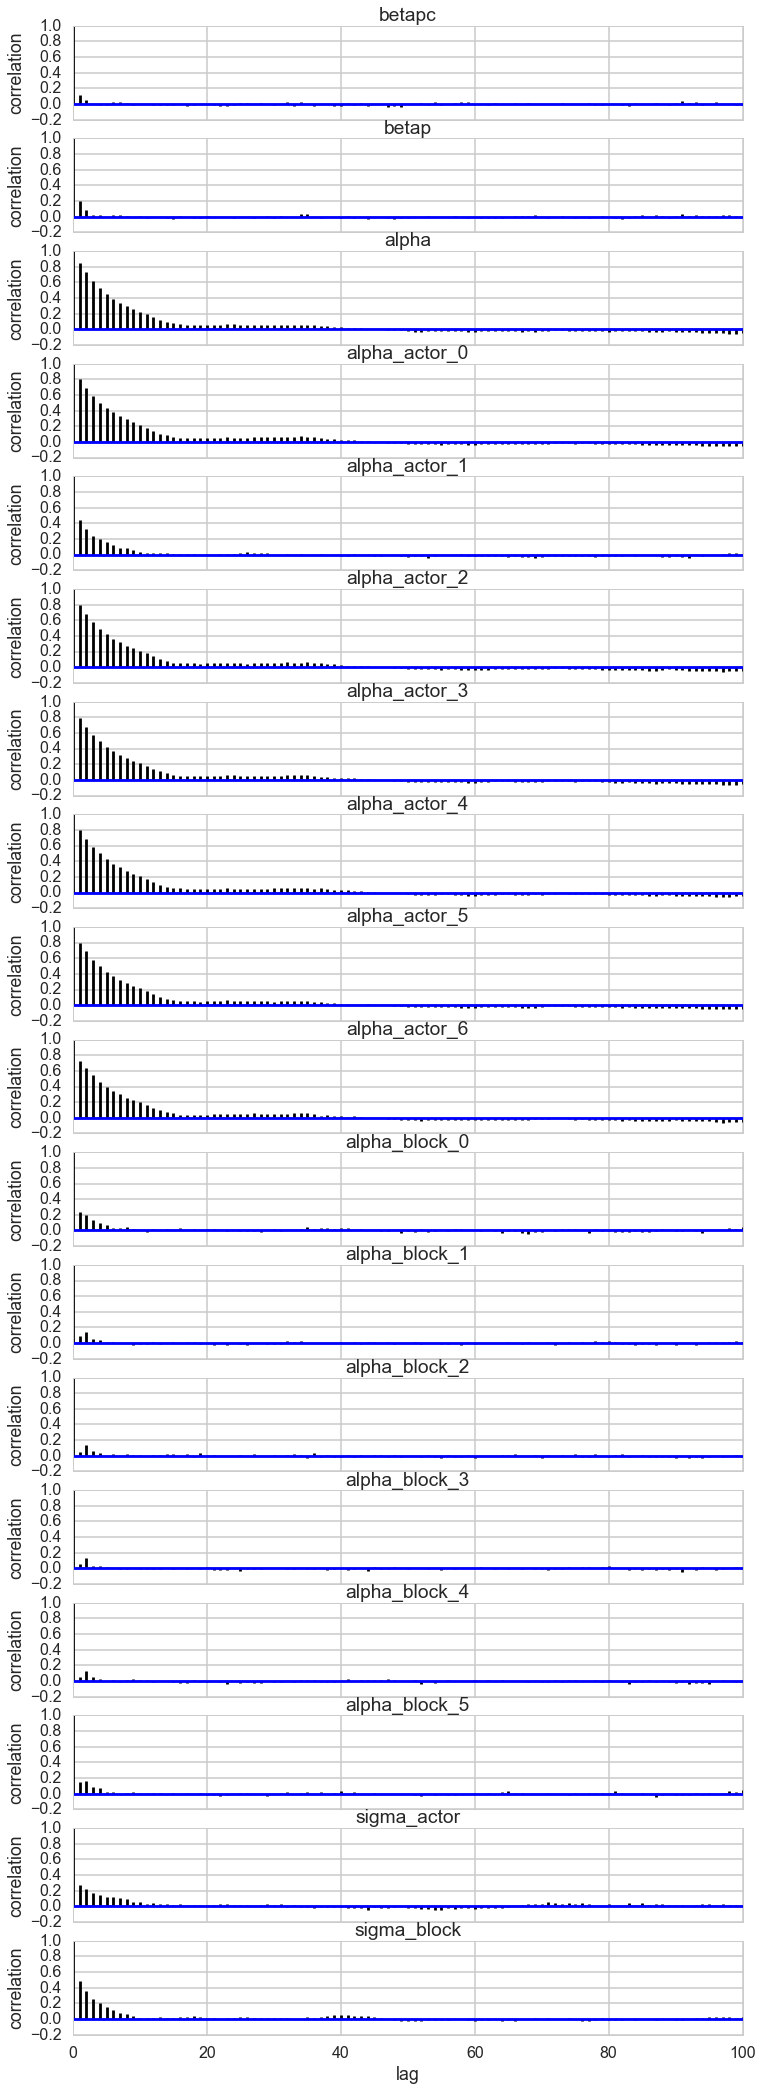

In [83]:
pm.autocorrplot(trace_vipb);

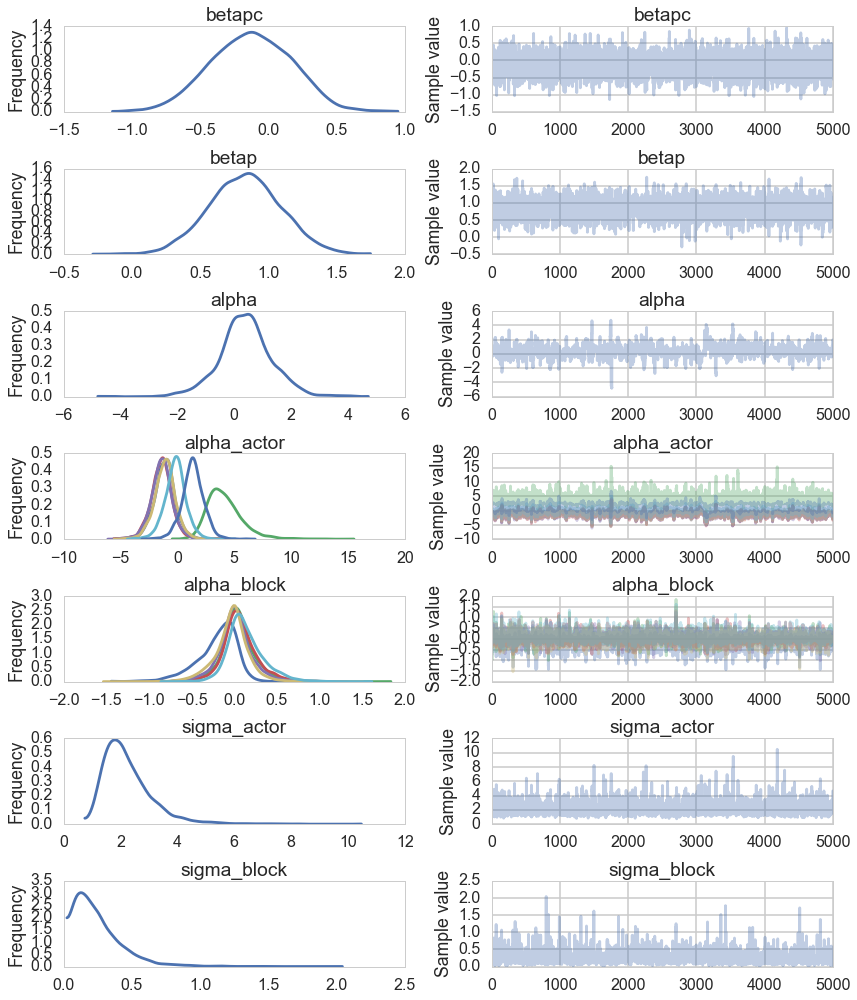

In [84]:
pm.traceplot(trace_vipb);

(array([   2.,    1.,    3.,    5.,    6.,   17.,   42.,   94.,  224.,
         539.,  980.,  944.,  719.,  478.,  335.,  222.,  147.,  106.,
          49.,   34.,   16.,   14.,    7.,    5.,    3.,    3.,    2.,
           0.,    2.,    1.]),
 array([-0.86028297, -0.77784083, -0.69539868, -0.61295653, -0.53051439,
        -0.44807224, -0.3656301 , -0.28318795, -0.20074581, -0.11830366,
        -0.03586152,  0.04658063,  0.12902277,  0.21146492,  0.29390706,
         0.37634921,  0.45879135,  0.5412335 ,  0.62367564,  0.70611779,
         0.78855993,  0.87100208,  0.95344423,  1.03588637,  1.11832852,
         1.20077066,  1.28321281,  1.36565495,  1.4480971 ,  1.53053924,
         1.61298139]),
 <a list of 30 Patch objects>)

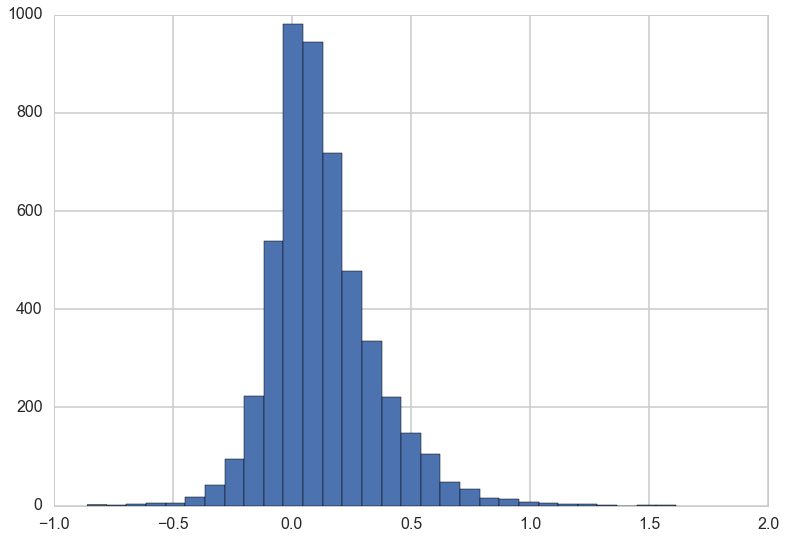

In [89]:
plt.hist(trace_vipb['alpha_block'][:,5], bins=30)

//anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(-1, 10)

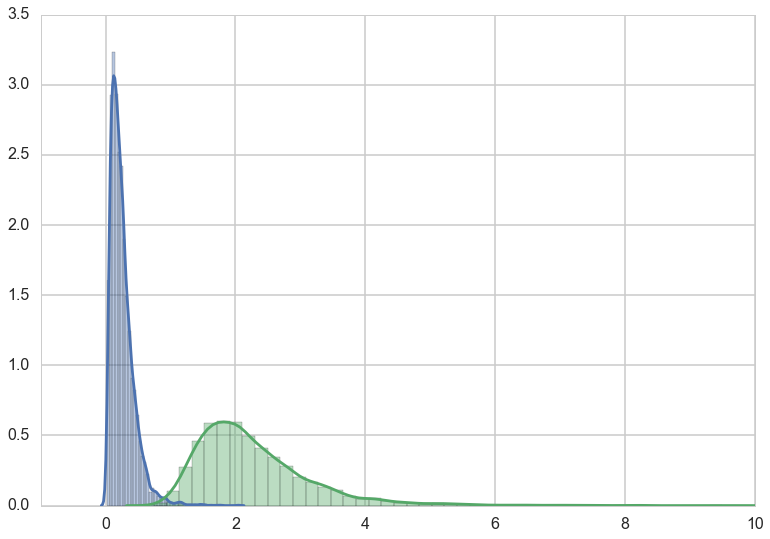

In [85]:
sns.distplot(trace_vipb['sigma_block'])
sns.distplot(trace_vipb['sigma_actor']);
plt.xlim([-1,10])

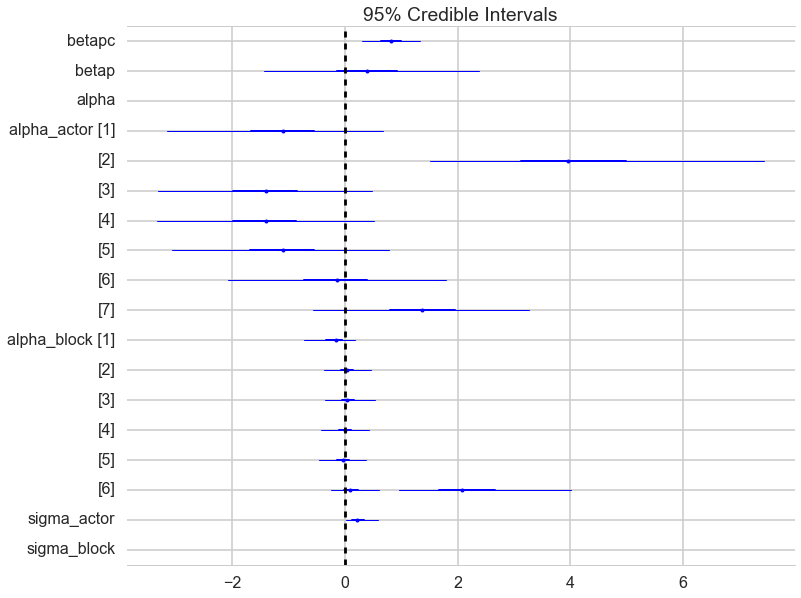

In [86]:
pm.forestplot(trace_vipb);

Do this and compare the WAICs.

In [90]:
dfc2=pm.compare([vi_trace, trace_vipb],[vi, vipb])

In [91]:
dfc2

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
0,531.538,8.19199,0,0.623301,19.5076,0,0
1,532.545,10.533,1.00717,0.376699,19.6731,0.183432,0


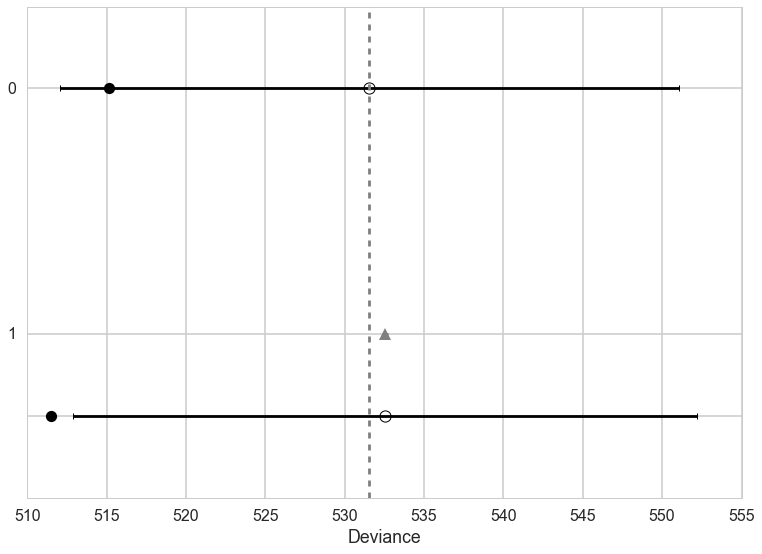

In [92]:
compare_plot(dfc2)